In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
from src.models import rnn

import numpy as np
import seaborn as sns
from typing import Callable, Optional
from torchtext.vocab import Vocab


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


In [3]:
len(testdataset) //32

104

We have 419 batches in the dataset

In [4]:
len(traindataset) // 32


419

In [5]:
len(traindataset)/32

419.09375

In [6]:
104+419

523

In [7]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [8]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-28 16:35:57.682 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [9]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [10]:
from collections import Counter

dataset = traindataset
list_labels = []
for i in range(len(dataset)):
    label = dataset[i][1]
    list_labels.append(label)

counter = Counter(list_labels)

for i in counter:
    percent_observations = counter[i]/len(dataset)
    print("{}: {}".format(i, percent_observations))

humor: 0.31414510476474533
wiki: 0.31175900380284843
proverbs: 0.06196405935426143
reuters: 0.3121318320781448


Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

ANSWER

1. What does this mean?

There are 4 categories, of which 3 have about the same number of observations, but the 4th one has significantly less observations. Therefore, the traindataset is unbalanced, where the class (proverbs) has less observations.

2. What implications does this have?

A different metric/loss function is necessary to measure accuracy.

3. Why is this good/bad?

The model will have a hard time to learn to classify proverbs, it will be biased towards the majority classes.

4. Things that could cause a problem down the line:

This dataset is not a balanced one, the category proverbs has significantly less observations available. The amount of observations in this class make up 6% of observations while the others all make up for around 31% of observations.


# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [11]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def __init__(self, max: int, vocab: Vocab, clean: Optional[Callable]) -> None:
        super().__init__(max, vocab, clean)

    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]


To test the preprocessor:

In [12]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [13]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [14]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 34]),
 tensor([2, 0, 2, 1, 0, 2, 0, 1, 0, 2, 3, 2, 0, 0, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1,
         1, 0, 1, 0, 0, 0, 1, 2]))

In [15]:
traindataset

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [16]:
from src.models import metrics
import torch


# F1 score metric is good for unbalanced datasets (which we have), this measure combines precision and recall. 
# Accuracy metric is also loaded to compare with F1 Score
metrics = [metrics.F1Score(), metrics.Accuracy()]

loss_fn = torch.nn.CrossEntropyLoss()


## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

NOTE -> TRAX

For the trax implementation, see src.models.rnnTrax
For the notebook (inc trainloop) running this model, see the notebook 02_StyleDetectionTrax.ipynb

In [17]:
from torchsummary import summary

log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.NLPmodel(config)



Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?

419

- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?

There are 103 batches in testset, so 523 in entire dataset.
523/25 = 20.92 = 21

- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 

419/25 = 16.76 = 17

- answer the questions above, and pick a reasonable epoch lenght

Picked 20 epochs


Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [18]:
from src.training import train_model

model = train_model.trainloop(
    epochs=20,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-06-28 16:36:01.438189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 16:36:01.438227: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-28 16:36:03.492 | INFO     | src.data.data_tools:dir_add_timestamp:65 - Logging to ../tune/20220628-1636
100%|██████████| 25/25 [00:11<00:00,  2.20it/s]
2022-06-28 16:36:15.787 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.2916 test 1.2702 metric ['0.1669', '0.3312']
100%|██████████| 25/25 [00:01<00:00, 13.87it/s]
2022-06-28 16:36:18.019 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.2308 test 1.2980 metric ['0.2845', '0.4213']
100%|██████████| 25/25 [00:01<00:00, 14.74it/s]
2022-06-28 16:36:20.237 | INFO     | src.training.train_model:trainloop:164 -

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

ANSWER

After 20 epochs, the model is still learning, in both the test and train loss we can see that loss is still decreasing. For further tuning, the amount of epochs should increase. The model is learning more slowly than at the start though, perhaps we can implement step-wise decrease of the learning rate to keep speedy learning at the beginning and change to a lower learning rate once the learning slows down. 

There are two metrics taken into account, the f1 score and accuracy. We should look mostly at the F1-score as this metric is better adapted to unbalanced datasets. It is visible that accuracy score is indeed significantly higher. F1-score is up to around 75% after 20 epochs.

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

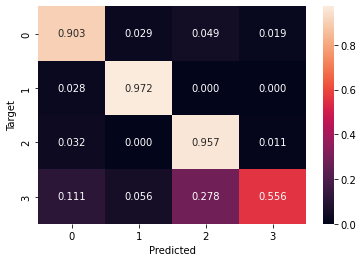

In [36]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder. -> figure saved as "confusionMatrix.png"

Interpret this. 

- What is going on?

The model performs relatively good for categories 0, 1, and 2, but underperforms significantly for category 3. This is because the model has a bias towards the first 3 categories, as they have many more observations. Most of the wrongly categorized items from category 3 (proverbs) are classified as 2 (wiki).

- What is a good metric here?

F1 score (precision/recall)

- how is your answer to Q1 relevant here?

Very, without having the knowledge of the dataset being unbalanced, it wouldn't have been clear why category 3 underperforms so much.

- Is there something you could do to fix/improve things, after you see these results?

Make the dataset balanced by oversampling the 3rd category or undersampling the first three categories. I would go for oversampling the 3rd (containing less observations) category, because otherwise many observations will be lost. Another way to deal with this is selecting a model (architecture) that deals well with unbalanced datasets.

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

EXPERIMENTS

1. Experiment one - Attention layer

Added an attention layer (AttentionNPL in src.models). This is basically the same model as NLPModel but with the addition of an attention layer. In the loss figures, it is visible that this model learns faster than the NLPModel. After 20 epochs, the f1 score of this model is 80% (whereas the base model got to 78% after 20 epochs). 

2. Experiment two - Add learning rate scheduler

Added a learning rate scheduler to the trainloop that starts with LR of 1e-3 and decreases the learning rate with factor of 0.9 if the model doesn't learn for 3 epochs. For this experiment, the number of epochs is also increased, as the model needs more time to plateau. The number of epochs is now set to 100. This model has an f1 score of 86% after 20 epochs. Learning rate has decreased from 1e-3 to 1.35e-4. The negative side of this model is that we see the test loss starting to increase after 60 epochs, this implies overtraining. In order to have less overtraining, we have to make the model a bit more simple, so that the model doesn't completely adapt to the training data. Therefore we now use only 2 GRU layers (instead of 3) with a dropout of 0.2 (instead of 0.1). This seems to work. The model has the same f1 score after 100 epochs, but test loss increases significanly less. 

3. Experiment three - Adjust for class imbalance
As we have unbalanced data, we can use the parameter "weights" of CrossEntropyLoss in oder to adjust for this class imbalance. In order to do this, we need to calculated the weights for each class. This is calculated by [total number of observations] / [number of observations] and make this calculation per class. In the cell below the weights are calculated. When I compare two models that are completely the same, except for the fact that one model has the crossentropyloss function with weights and the other has no weights of classes, the f1 score increases by 3% (see figure "F1ScoreWeighted", where the green line is the model with weighted loss). The results are better visible in the confustion matrix, see figure "confusionmatrixweighted.png". 
 

FOR FURTHER EXPERIMENTATION - SEE TRAX NOTEBOOK (02_style_detection_trax.ipynb)






In [25]:
from sklearn import utils

def cast_label(label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]

intlabels = [cast_label(i) for i in list_labels]
weights = utils.class_weight.compute_class_weight("balanced", classes = np.unique(intlabels), y= np.array(intlabels))
weights = torch.tensor(weights, dtype=torch.float)
print(weights)
loss_fn = torch.nn.CrossEntropyLoss(weight = weights)

tensor([0.7958, 0.8009, 0.8019, 4.0346])


In [19]:
from src.training import train_model

model = train_model.trainloop(
    epochs=20,
    model=rnn.AttentionNLP(config),
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-06-25 15:17:59.467 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220625-1517
100%|██████████| 25/25 [00:04<00:00,  5.88it/s]
2022-06-25 15:18:04.703 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.2686 test 1.1356 metric ['0.3617', '0.4675']
100%|██████████| 25/25 [00:04<00:00,  6.03it/s]
2022-06-25 15:18:09.550 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.1025 test 0.9567 metric ['0.3939', '0.5413']
100%|██████████| 25/25 [00:02<00:00, 11.06it/s]
2022-06-25 15:18:12.281 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.9200 test 0.8157 metric ['0.5298', '0.6950']
100%|██████████| 25/25 [00:01<00:00, 14.71it/s]
2022-06-25 15:18:14.481 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.7423 test 0.6713 metric ['0.6368', '0.7600']
100%|██████████| 25/25 [00:01<00:00, 14.80it/s]
2022-06-25 15:18:16.631 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train

In [37]:
from src.training import train_model

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "output_size": 4,
}


model = train_model.trainloop(
    epochs=80,
    model=rnn.AttentionNLP(config),
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    patience = 3,
    factor = 0.9,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=50,
    eval_steps=50,
)

2022-06-28 16:48:27.842 | INFO     | src.data.data_tools:dir_add_timestamp:65 - Logging to ../tune/20220628-1648
100%|██████████| 50/50 [00:13<00:00,  3.66it/s]
2022-06-28 16:48:42.474 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.2191 test 0.9724 metric ['0.5860', '0.6525']
100%|██████████| 50/50 [00:03<00:00, 13.34it/s]
2022-06-28 16:48:47.225 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 0.8469 test 0.7706 metric ['0.5946', '0.6706']
100%|██████████| 50/50 [00:03<00:00, 13.51it/s]
2022-06-28 16:48:51.861 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.6983 test 0.6856 metric ['0.6990', '0.7788']
100%|██████████| 50/50 [00:03<00:00, 14.78it/s]
2022-06-28 16:48:56.266 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.5872 test 0.6205 metric ['0.6875', '0.7569']
100%|██████████| 50/50 [00:03<00:00, 14.06it/s]
2022-06-28 16:49:00.896 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train

KeyboardInterrupt: 